# Automatically getting S&P 500 list


### Pulling up all the libraries
    

In [1]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import pickle ##helps in serializing the object
import requests
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from collections import Counter

from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


C:\Users\gupta\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def save_sp500_tickers():
    resp=requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup=bs.BeautifulSoup(resp.text,"lxml")
    
    table=soup.find('table',{'class':'wikitable sortable'})
    tickers=[]
    for row in table.findAll('tr')[1:]:
        ticker=row.findAll('td')[0].text
        tickers.append(ticker)
    
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
    return(tickers)

                        

### Getting information from Yahoo finance for all the companies

In [3]:
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers=save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f) #read bytes
            
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start = dt.datetime(2000,1,1)
    end=dt.datetime(2016,12,31)
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df= web.DataReader(ticker,'yahoo',start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
                              


### Calling the function

In [4]:
get_data_from_yahoo()

MMM
Already have MMM
ABT
Already have ABT
ABBV
Already have ABBV
ACN
Already have ACN
ATVI
Already have ATVI
AYI
Already have AYI
ADBE
Already have ADBE
AAP
Already have AAP
AES
Already have AES
AET
Already have AET
AMG
Already have AMG
AFL
Already have AFL
A
Already have A
APD
Already have APD
AKAM
Already have AKAM
ALK
Already have ALK
ALB
Already have ALB
AGN
Already have AGN
LNT
Already have LNT
ALXN
Already have ALXN
ALLE
Already have ALLE
ADS
Already have ADS
ALL
Already have ALL
GOOGL
Already have GOOGL
GOOG
Already have GOOG
MO
Already have MO
AMZN
Already have AMZN
AEE
Already have AEE
AAL
Already have AAL
AEP
Already have AEP
AXP
Already have AXP
AIG
Already have AIG
AMT
Already have AMT
AWK
Already have AWK
AMP
Already have AMP
ABC
Already have ABC
AME
Already have AME
AMGN
Already have AMGN
APH
Already have APH
APC
Already have APC
ADI
Already have ADI
ANTM
Already have ANTM
AON
Already have AON
APA
Already have APA
AIV
Already have AIV
AAPL
Already have AAPL
AMAT
Already h

In [5]:
def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers= pickle.load(f)
        
    main_df= pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        df=pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns = {'Adj Close': ticker}, inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
        
        if main_df.empty:
            main_df=df
        else:
            main_df= main_df.join(df, how='outer')
            
        if count %10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [6]:
compile_data()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
                  MMM       ABT  ABBV  ACN      ATVI  AYI       ADBE  AAP  \
Date                                                                        
2000-01-03  31.131128  9.517434   NaN  NaN  1.259640  NaN  16.274673  NaN   
2000-01-04  29.894130  9.245507   NaN  NaN  1.221324  NaN  14.909400  NaN   
2000-01-05  30.760029  9.228512   NaN  NaN  1.226114  NaN  15.204175  NaN   
2000-01-06  33.234026  9.551425   NaN  NaN  1.202166  NaN  15.328291  NaN   
2000-01-07  33.893758  9.653397   NaN  NaN  1.235693  NaN  16.072985  NaN   

                  AES       AET ...        XEL        XRX       XLNX  \
Date                            ...                                    
2000-01-03  32.346420  6.290820 ...   8.665217  12.447396  35.497325   
2000-01-04  31.063717  6.184675 ...   8.864745  11.

# Company Corelation Table

In [7]:
#trying to just test on a graph that wheher we can plot it or not
def visualize_data():
    df= pd.read_csv('sp500_joined_closes.csv')
    df['VZ'].plot()
    plt.show()
    df_corr = df.corr() ##corellation table of our dataframe
    
    ##print(df_corr.head()) ##display the header for the correlation
    
    data= df_corr.values
    fig = plt.figure()
    ax=fig.add_subplot(1,1,1)
    
    heatmap= ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    
    ###building the graphs, it will plot color and we want to tick the marks, we are adding ticks and labels
    ax.set_xticks(np.arange(data.shape[0])+.5, minor= False)
    ax.set_yticks(np.arange(data.shape[1])+.5, minor= False)
    ax.invert_yaxis() ###we do it to remove gap from top of the graph
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    
    plt.show()
    


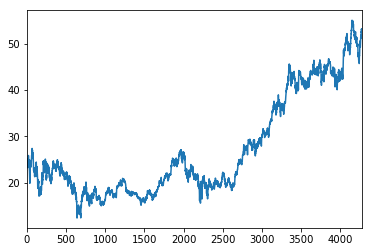

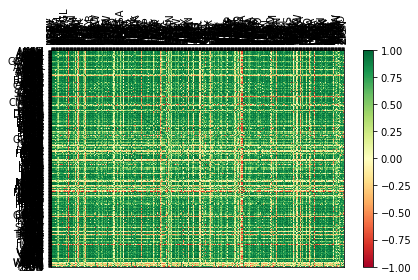

In [8]:
visualize_data()

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z='sp500_joined_closes.csv')
data=[trace]
py.iplot(data, filename='basic-heatmap')

### Process Data for Machine Learning

In [11]:
def process_data_for_labels(ticker):
    hm_days=7
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i)- df[ticker])/df[ticker]


    df.fillna(0, inplace=True)
    return tickers, df

process_data_for_labels('VZ')

(['MMM',
  'ABT',
  'ABBV',
  'ACN',
  'ATVI',
  'AYI',
  'ADBE',
  'AAP',
  'AES',
  'AET',
  'AMG',
  'AFL',
  'A',
  'APD',
  'AKAM',
  'ALK',
  'ALB',
  'AGN',
  'LNT',
  'ALXN',
  'ALLE',
  'ADS',
  'ALL',
  'GOOGL',
  'GOOG',
  'MO',
  'AMZN',
  'AEE',
  'AAL',
  'AEP',
  'AXP',
  'AIG',
  'AMT',
  'AWK',
  'AMP',
  'ABC',
  'AME',
  'AMGN',
  'APH',
  'APC',
  'ADI',
  'ANTM',
  'AON',
  'APA',
  'AIV',
  'AAPL',
  'AMAT',
  'ADM',
  'ARNC',
  'AJG',
  'AIZ',
  'T',
  'ADSK',
  'ADP',
  'AN',
  'AZO',
  'AVB',
  'AVY',
  'BHI',
  'BLL',
  'BAC',
  'BK',
  'BCR',
  'BAX',
  'BBT',
  'BDX',
  'BBBY',
  'BRK-B',
  'BBY',
  'BIIB',
  'BLK',
  'HRB',
  'BA',
  'BWA',
  'BXP',
  'BSX',
  'BMY',
  'AVGO',
  'BF-B',
  'CHRW',
  'CA',
  'COG',
  'CPB',
  'COF',
  'CAH',
  'HSIC',
  'KMX',
  'CCL',
  'CAT',
  'CBG',
  'CBS',
  'CELG',
  'CNC',
  'CNP',
  'CTL',
  'CERN',
  'CF',
  'SCHW',
  'CHTR',
  'CHK',
  'CVX',
  'CMG',
  'CB',
  'CHD',
  'CI',
  'XEC',
  'CINF',
  'CTAS',
  'CSCO',


### Label Buy, Sell Hold for the companies


In [12]:
def buy_sell_hold(*args): #args allows us to pass any number of arguments and becomes iteratable
    cols=[c for c in args]
    requirement = .02 # percentage change from the previous 7 days then we will do computation
    for col in cols:
        if col> requirement:
            return 1 #buy
        if col< -requirement:
            return -1 #sell
    return 0 #hold

    

### Map to the columns

In [13]:
def extract_featuresets(ticker):
    tickers,df=process_data_for_labels(ticker)
    df['{}_target'.format(ticker)]=list(map(buy_sell_hold,
                                            df['{}_1d'.format(ticker)],
                                            df['{}_2d'.format(ticker)],
                                            df['{}_3d'.format(ticker)],
                                            df['{}_4d'.format(ticker)],
                                            df['{}_5d'.format(ticker)],
                                            df['{}_6d'.format(ticker)],
                                            df['{}_7d'.format(ticker)]))
    vals=df['{}_target'.format(ticker)].values.tolist()
    str_vals=[str(i) for i in vals]
    print('Data spread:', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df= df.replace([np.inf,-np.inf],np.nan)
    df.dropna(inplace=True)
    
    #create the feature set and labels
    df_vals=df[[ticker for ticker in tickers]].pct_change() #normalized
    df_vals = df_vals.replace([np.inf,-np.inf],0)
    df_vals.fillna(0,inplace=True)
    
    X = df_vals.values
    y=df['{}_target'.format(ticker)].values
    
    return X,y, df

In [14]:
extract_featuresets('VZ')

Data spread: Counter({'1': 1675, '-1': 1499, '0': 1103})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03973508, -0.02857146,  0.        , ...,  0.        ,
         -0.04842343,  0.        ],
        [ 0.02896552, -0.00183819,  0.        , ...,  0.        ,
         -0.00118343,  0.        ],
        ..., 
        [-0.00469482, -0.00984448, -0.00367999, ...,  0.00155487,
         -0.01479631, -0.00521226],
        [ 0.00185311,  0.00235478,  0.00738717, ...,  0.00426938,
         -0.01132159,  0.00336827],
        [ 0.00089683,  0.00261025, -0.00175354, ..., -0.00289858,
          0.0058425 , -0.00167847]]),
 array([-1,  1, -1, ...,  0,  0,  0], dtype=int64),
                    MMM        ABT       ABBV         ACN       ATVI  \
 Date                                                                  
 2000-01-03   31.131128   9.517434   0.000000    0.000000   1.259640   
 2000-01-04   29.894130   9.245507   0.000000    0.000000   1.221324   
 2000-01-05   30.760029   9.2285

### Do the machine learning

In [32]:
def do_ml(ticker):
    X,y,df=extract_featuresets(ticker)
    
    X_train, X_test, y_train, y_test= cross_validation.train_test_split(X,
                                                                       y,
                                                                       test_size=0.25)
    #clf= neighbors.KNeighborsClassifier()
    clf = VotingClassifier([('lsvc',svm.LinearSVC()),
                            ('gsvc',svm.SVC(kernel="linear", C=0.025),),
                            ('gmsvc',svm.SVC(gamma=2, C=1)),
                            ('knn', neighbors.KNeighborsClassifier(3)),
                            ('rfor',RandomForestClassifier()),
                            ('rfor1',RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
                            ('dtr',DecisionTreeClassifier(max_depth=5)),
                            ('mlp',MLPClassifier(alpha=1)),
                            ('abc',AdaBoostClassifier()),
                            ('gnb',GaussianNB()),
                            ('qda',QuadraticDiscriminantAnalysis())
                           ])
    clf.fit(X_train,y_train)
    
    confidence = clf.score(X_test, y_test)
    print('Accuracy:',confidence)
    predictions=clf.predict(X_test)
    
    print('Predicted values:', Counter(predictions))
    
    return confidence

    
     

In [33]:
do_ml('VZ')

Data spread: Counter({'1': 1675, '-1': 1499, '0': 1103})
Accuracy: 0.417757009346
Predicted values: Counter({1: 678, -1: 212, 0: 180})


0.41775700934579441